In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#unzip Autopilot folder as data is inside there
!unzip /content/drive/Car_data_set/Autopilot-TensorFlow-master.zip >temp.txt


In [1]:
!ls /content/Autopilot-TensorFlow-master/

cmd_output	 logs	      run_dataset.py  Self_driving_car.ipynb
driving_data.py  model.py     run.py	      steering_wheel_image.jpg
driving_dataset  __pycache__  save	      train.py
License.txt	 README.md    save copy


In [1]:
import numpy as np
import pandas as pd
import os, shutil
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy import pi
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D

from keras.regularizers import l2
from keras.optimizers import Adam
import tensorflow as tf
import scipy

Using TensorFlow backend.


In [2]:
xs = []
ys = []
original_data_path = r"/content/Autopilot-TensorFlow-master/driving_dataset"
#train_data_path = r"/content/Autopilot-TensorFlow-master/train_driving_dataset"
#val_data_path = r"/content/Autopilot-TensorFlow-master/val_driving_dataset"
#test_data_path = r"/content/Autopilot-TensorFlow-master/test_driving_dataset"

#read data.txt
with open(original_data_path +"/data.txt") as f:
    for line in f:
        xs.append(original_data_path+"/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * pi / 180)

#get number of images
num_images = len(xs)
val_start_point = int(len(xs) * 0.8)
val_end_point = int(len(xs))
                      
train_xs = xs[:val_start_point]
train_ys = ys[:val_start_point]
val_xs = xs[val_start_point : val_end_point]
val_ys = ys[val_start_point : val_end_point]
test_xs = xs[val_end_point:]
test_ys = ys[val_end_point:]
print("Total Number of Data-set: "+str(num_images))
print("Total Number of Train Data-set: "+str(len(train_xs)))
print("Total Number of Validation Data-set: "+str(len(val_xs)))
print("Total Number of Test Data-set: "+str(len(test_xs)))



Total Number of Data-set: 45406
Total Number of Train Data-set: 36324
Total Number of Validation Data-set: 9082
Total Number of Test Data-set: 0


In [0]:
read_image_height=66
read_image_width=200

image_height=66
image_width=200
channels = 3

In [3]:
read_image_height=66
read_image_width=200

image_height=66
image_width=200
channels = 3

train_dataset = np.ndarray(shape=(len(train_xs), image_height, image_width, channels),
                     dtype=np.float32)
val_dataset = np.ndarray(shape=(len(val_xs), image_height, image_width, channels),
                     dtype=np.float32)
test_dataset = np.ndarray(shape=(len(test_xs), image_height, image_width, channels),
                     dtype=np.float32)

i = 0
for file in train_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x /= 255.0
    #train_dataset[i] = x[20:60,:,:]
    train_dataset[i] = x
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
print("All Train images to array!")


i = 0
for file in val_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x /= 255.0
    #val_dataset[i] = x[20:60,:,:]
    val_dataset[i] = x
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
print("All validation images to array!")        

"""
i = 0
for file in test_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x *= 1./255
    test_dataset[i] = x[75:175,:,:]
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
        
print("All Test images to array!")

"""

10000 images to array
20000 images to array
30000 images to array
All Train images to array!
All validation images to array!


'\ni = 0\nfor file in test_xs:\n    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)\n    # Convert to Numpy Array\n    x = img_to_array(img)  \n    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img\n    # Normalize\n    x *= 1./255\n    test_dataset[i] = x[75:175,:,:]\n    del(x)\n    i += 1\n    if i % 10000 == 0:\n        print("%d images to array" % i)\n        \nprint("All Test images to array!")\n\n'

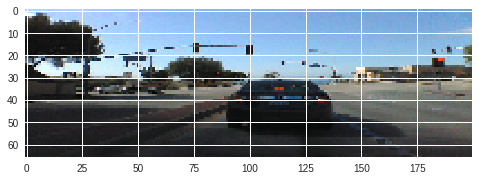

In [9]:
plt.imshow(train_dataset[10000])
plt.show()

In [0]:
#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0
batch_size=100

num_train_images = len(train_xs)
num_val_images = len(val_xs)

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    while 1:
      for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
      train_batch_pointer += batch_size
      yield np.asarray(x_out), np.asarray(y_out)

def LoadValBatch():
    global val_batch_pointer
    x_out = []
    y_out = []
    while 1:
      for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
      val_batch_pointer += batch_size
      yield np.asarray(x_out), np.asarray(y_out)


In [0]:
def atan(x):
  return 2*K.tf.atan(x)

In [8]:
#create small model
input_size = (image_height,image_width,channels)
#crop_size = ((75,25),(10,10))
act_funct = "relu"
init = "he_normal"
l2_rate = 0.0001
keep_prob = 0
keep_prob_dense = 0.2
def create_model():
  model = Sequential()
  
  model.add(Conv2D(24, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(36, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(48, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(64, (3, 3),strides=(1, 1), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(64, (3, 3),strides=(1, 1),padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  
  #FC dence layer
  model.add(Flatten())
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(1164, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(100, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(50, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(10, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  #arctanh
  model.add(Dense(1,activation=atan))
  #model.add(Dense(1))
  return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1152)              0         
__________

In [0]:
adam = Adam(lr=0.0001)
model.compile(loss='mse',optimizer=adam)

In [0]:
#history = model.fit_generator(train_generator,steps_per_epoch=t_steps_per_e,epochs=ep,validation_data=val_generator,validation_steps=v_steps_per_e)
#history = model.fit(x=train_dataset, y=train_ys, batch_size=100, epochs=60, verbose=1, validation_data=(val_dataset,val_ys))

model.fit_generator(LoadTrainBatch(100) ,steps_per_epoch=1000, nb_epoch=30, verbose = 1,validation_data=LoadValBatch(),validation_steps=90)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1000, verbose=1, validation_data=<generator..., validation_steps=90, epochs=30)`
  


Epoch 1/30


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


  23/1000 [..............................] - ETA: 34:00 - loss: 3.0346

In [0]:
from keras.layers import ELU

In [0]:
init = 'glorot_normal'
        activation = 'relu'
        keep_prob_dense = 0.7
        keep_prob = 0.5
        
        model = Sequential()
        
        ### pre-processing
        model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        ### Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 convolution factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(36,3,1, init=init))
        model.add(Convolution2D(36,1,3, init=init))
        model.add(Convolution2D(36,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 factorfization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(48,1,3, init=init))
        model.add(Convolution2D(48,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        
        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # average pooling
        model.add(AveragePooling2D(pool_size=(1,6)))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)

In [21]:
#create small model
input_size = (image_height,image_width,channels)
act_funct = "relu"
def create_model():
  model = Sequential()
  #model.add(Conv2D(12, (1, 1), activation=act_funct,input_shape=input_size)) #inception layer
  model.add(Conv2D(16, (8, 8), strides=(4, 4), padding="same",input_shape=input_size))
  model.add(ELU())
  model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
  model.add(ELU())
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))
  return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 17, 25, 16)        3088      
_________________________________________________________________
elu_9 (ELU)                  (None, 17, 25, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 9, 13, 32)         12832     
_________________________________________________________________
elu_10 (ELU)                 (None, 9, 13, 32)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 5, 7, 64)          51264     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2240)              0         
__________